In [1]:
from pathlib import Path

import imageio
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange

from flygym import Fly, Camera
from flygym.arena import OdorArena
from flygym.examples.turning_controller import HybridTurningNMF

In [2]:
plt.rcParams["font.family"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42

In [3]:
odor_source = np.array([[24, 0, 1.5], [8, -4, 1.5], [16, 4, 1.5]])
peak_odor_intensity = np.array([[1, 0], [0, 1], [0, 1]])

color_cycle_rgb = [[31, 119, 180], [255, 127, 14]]


def run_trial(
    spawn_pos,
    spawn_orientation,
    odor_source,
    peak_odor_intensity,
    attractive_gain=500,
    aversive_gain=80,
    run_time=5,
    video_path=None,
):
    marker_colors = [color_cycle_rgb[i] for i in [1, 0, 0]]
    marker_colors = np.array([[*np.array(color) / 255, 1] for color in marker_colors])
    odor_history = []
    arena = OdorArena(
        size=(300, 300),
        odor_source=odor_source,
        peak_odor_intensity=peak_odor_intensity,
        diffuse_func=lambda x: x**-2,
        marker_colors=marker_colors,
        marker_size=0.3,
    )

    contact_sensor_placements = [
        f"{leg}{segment}"
        for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
        for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
    ]

    fly = Fly(
        enable_olfaction=True,
        enable_adhesion=True,
        draw_adhesion=False,
        spawn_pos=spawn_pos,
        spawn_orientation=spawn_orientation,
        contact_sensor_placements=contact_sensor_placements,
    )

    cam = Camera(
        fly=fly,
        camera_id="birdeye_cam_zoom",
        fps=30,
        play_speed=0.5,
        window_size=(700, 560),
    )

    sim = HybridTurningNMF(
        fly=fly,
        cameras=[cam],
        arena=arena,
        timestep=1e-4,
    )

    obs_hist = []
    attractive_bias_hist = []
    aversive_bias_hist = []
    stearing_hist = []
    decision_interval = 0.05
    num_decision_steps = int(run_time / decision_interval)
    physics_steps_per_decision_step = int(decision_interval / sim.timestep)

    obs, _ = sim.reset(seed=0)
    for i in trange(num_decision_steps):
        attractive_intensities = np.average(
            obs["odor_intensity"][0, :].reshape(2, 2), axis=0, weights=[1, 9]
        )
        aversive_intensities = np.average(
            obs["odor_intensity"][1, :].reshape(2, 2), axis=0, weights=[0, 10]
        )
        attractive_bias = (
            attractive_gain
            * (attractive_intensities[0] - attractive_intensities[1])
            / attractive_intensities.mean()
        )
        aversive_bias = (
            aversive_gain
            * (aversive_intensities[0] - aversive_intensities[1])
            / aversive_intensities.mean()
        )
        effective_bias = aversive_bias - attractive_bias

        effective_bias_norm = np.tanh(effective_bias**2) * np.sign(effective_bias)
        assert np.sign(effective_bias_norm) == np.sign(effective_bias)
        control_signal = np.ones((2,))
        control_signal[int(effective_bias_norm > 0)] -= (
            np.abs(effective_bias_norm) * 0.8
        )

        for j in range(physics_steps_per_decision_step):
            obs, _, _, _, _ = sim.step(control_signal)
            rendered_img = sim.render()[0]
            if rendered_img is not None:
                # record odor intensity too for video
                odor_history.append(obs["odor_intensity"])
        obs_hist.append(obs)
        attractive_bias_hist.append(attractive_bias)
        aversive_bias_hist.append(aversive_bias)
        stearing_hist.append(effective_bias_norm)

        if np.linalg.norm(obs["fly"][0, :2] - odor_source[0, :2]) < 2:
            break

    if video_path is not None:
        cam.save_video(video_path)

    return (
        sim,
        obs_hist,
        attractive_bias_hist,
        aversive_bias_hist,
        stearing_hist,
        odor_history,
    )

In [4]:
(
    sim,
    obs_hist,
    attractive_bias_hist,
    aversive_bias_hist,
    stearing_hist,
    odor_hist,
) = run_trial(
    spawn_pos=(0, 0, 0.2),
    spawn_orientation=[0, 0, np.pi / 2],
    run_time=5,
    odor_source=odor_source,
    peak_odor_intensity=peak_odor_intensity,
    video_path=None,
)

 44%|████▍     | 44/100 [00:36<00:46,  1.20it/s]


In [5]:
def add_insets(
    viz_frame, odor_intensities, odor_colors, odor_gain=500, panel_height=150
):
    final_frame = np.zeros(
        (viz_frame.shape[0] + panel_height + 5, viz_frame.shape[1], 3), dtype=np.uint8
    )
    final_frame[: viz_frame.shape[0], :, :] = viz_frame

    assert np.array(odor_intensities).shape == (2, 4)
    odor_intensities = np.array(odor_intensities).reshape(2, 2, 2).mean(axis=1)
    unit_size = panel_height // 5

    for i_odor in range(2):
        for i_side in range(2):
            row_start = unit_size + i_odor * unit_size * 2 + viz_frame.shape[0] + 5
            row_end = row_start + unit_size
            width = int(odor_intensities[i_odor, i_side] * odor_gain)
            if i_side == 0:
                col_start = 0
                col_end = width
            else:
                col_start = final_frame.shape[1] - width
                col_end = final_frame.shape[1]
            final_frame[row_start:row_end, col_start:col_end, :] = odor_colors[i_odor]

    return final_frame

In [6]:
cam = sim.cameras[0]

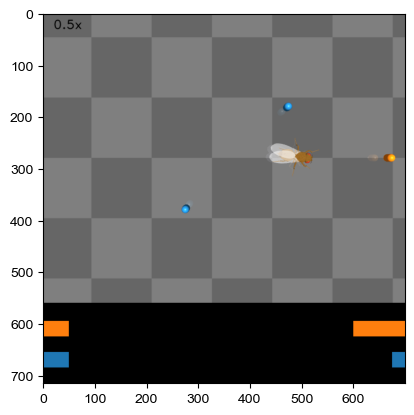

In [7]:
inset = add_insets(
    cam._frames[100],
    [[0.1, 0.2, 0.1, 0.2], [0.1, 0.05, 0.1, 0.05]],
    [color_cycle_rgb[1], color_cycle_rgb[0]],
)
plt.imshow(inset)

In [8]:
stabilization_time = 0.02
num_stab_frames = int(np.ceil(stabilization_time / cam._eff_render_interval))

path = Path("outputs/odor_taxis.mp4")
path.parent.mkdir(parents=True, exist_ok=True)
with imageio.get_writer(path, fps=cam.fps) as writer:
    for i, (frame, odor_intensities) in enumerate(
        zip(cam._frames, odor_hist, strict=True)
    ):
        if i >= num_stab_frames:
            frame = add_insets(
                frame,
                odor_intensities,
                odor_gain=500,
                odor_colors=[color_cycle_rgb[1], color_cycle_rgb[0]],
            )
            writer.append_data(frame)

[swscaler @ 0x5bd5c00] Warning: data is not aligned! This can lead to a speed loss


In [9]:
save_individual_frames = False

individual_frames_dir = Path("outputs/individual_frames")
snapshot_interval_frames = 25
frames = cam._frames
offset = len(frames) % snapshot_interval_frames - 1
snapshots = np.array(
    [frames[i] for i in range(offset, len(frames), snapshot_interval_frames)]
)
background = np.median(snapshots, axis=0).astype(np.uint8)

if save_individual_frames:
    individual_frames_dir.mkdir(parents=True, exist_ok=True)
    imageio.imwrite(individual_frames_dir / "background.png", background)

imgs = []

for i in trange(0, snapshots.shape[0]):
    img = snapshots[i, :, :, :]
    is_background = np.isclose(img, background, atol=1).all(axis=2)
    img_alpha = np.ones((img.shape[0], img.shape[1], 4)) * 255
    img_alpha[:, :, :3] = img
    img_alpha[is_background, 3] = 0
    img_alpha = img_alpha.astype(np.uint8)
    imgs.append(img_alpha)

    if save_individual_frames:
        imageio.imwrite(individual_frames_dir / f"frame_{i}.png", img_alpha)

100%|██████████| 6/6 [00:00<00:00, 98.01it/s]


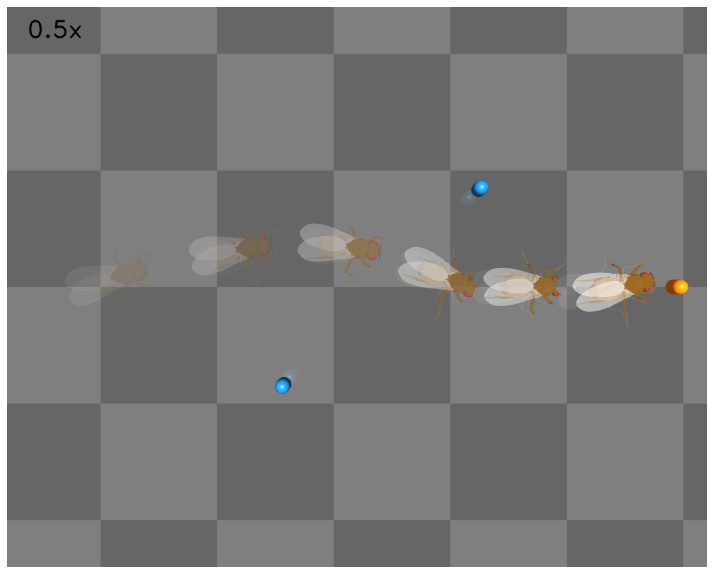

In [10]:
dpi = 72
h, w = background.shape[:2]

fig, ax = plt.subplots(figsize=(w / dpi, h / dpi), dpi=72)
ax.imshow(background)
ax.axis("off")

for i, img in enumerate(imgs):
    ax.imshow(img, alpha=(i + 1) / len(imgs))

fig.subplots_adjust(0, 0, 1, 1, 0, 0)
plt.savefig("outputs/odor_taxis.pdf", dpi=dpi)